# dSTRF
Code from Matt https://github.com/NeuroTheoryUMD/mattjac/blob/4b9a97f124a6fa22b6e6754b7519e00274ad03e3/v1/lib/predict.py

December 2, 2025

In [1]:
%load_ext autoreload
%autoreload 2

#import predict
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
from torch.func import jacrev, jacfwd, vmap, vjp
from memory_profiler import memory_usage
from imports import *
#import mattjac.v1.lib.predict as predict
datadir, dirname, device, device0 = init_vars('simcloud', GPU=1)

2026 February 6: ifernand running on sc
Device assigned: cuda:1
Loaded additional packages:
  scd spu readout_fit BC 
Datadir: /data/Antolik/
Dirname: /home/ifernand/


## Load Data

In [ ]:
start    = time()
data     = scd.SimCloudData(down_sample=3, num_lags=11)
end      = time()
print('CPU Time', end-start, 'sec')

In [ ]:
NC = data.NC
NT = data.NT
block_len = data.block_len
NB = data.NB
L  = data.stim_dims[1]
num_lags = data.num_lags
print('Number of cells', NC)
print('Number of time points', NT)
print('Block length:', block_len)
print('Number of blocks:', NB)
print('L =', L)
print('num lags:', num_lags)

## Load Model

In [ ]:
torch.no_grad()

In [ ]:
cnn = NDN.load_model('models/width_test_12-23-25/2026-01-01_04-54-07_NDN491_Q5_R1_width_16-12-12_GQMmu_seed100.ndn')
#cnn = NDN.load_model('models/width_test_12-23-25/2025-12-23_15-09-13_NDN491_Q5_R1_width_4-2-2_GQMmu_seed100.ndn')
cnn.eval()
cnn.block_sample = True
cnn.loss_module.unit_weighting = True
print(cnn.info())
print(cnn.list_parameters())

## Choose cells

In [ ]:
Qmu = deepcopy(cnn.networks[1].layers[0].Qmu.data).numpy()[:,0]
delta_Qmu = 2/6
Qmu_range = (-1 , -1 + delta_Qmu)
cell_list = np.where((Qmu>=Qmu_range[0])*(Qmu<=Qmu_range[1]))[0]
Qmu_range, cell_list.shape

In [ ]:
cell_list

## Make temp model

In [ ]:
num_layers_list = []
# LGN Layer
layer0 = deepcopy(cnn.networks[0].layers[0])
clayers = [STconvLayer.layer_dict( 
    input_dims = data.stim_dims, num_filters=layer0.num_filters, norm_type=1,
    filter_dims=layer0.filter_dims , bias=False, NLtype='relu',
    padding='same', output_norm='batch', window='hamming', initialize_center=True,
    reg_vals=layer0.reg.vals )]

# PROJECTION LAYER
layer1 = deepcopy(cnn.networks[0].layers[1])
num_layers_list.append(layer1.num_filters)
clayers.append(ConvLayer.layer_dict(
    num_filters=layer1.num_filters, num_inh=layer1.num_inh,
    bias=False, norm_type=1, initialize_center=True, window='hamming', output_norm='batch',
    filter_dims=layer1.filter_dims[1], NLtype='relu', reg_vals=layer1.reg.vals))

# TIME SHIFT LAYER
clayers.append(TimeShiftLayer.layer_dict())

# REST
for ii in range(3,5):
    layerX = deepcopy(cnn.networks[0].layers[ii])
    num_layers_list.append(layerX.num_filters)
    clayers.append(ConvLayer.layer_dict(
        num_filters=layerX.num_filters, num_inh=layerX.num_inh, filter_dims=layerX.filter_dims[1],
        bias=False, norm_type=1, initialize_center=True, output_norm='batch',
        NLtype='relu'))

scaffold_net =  FFnetwork.ffnet_dict(
    ffnet_type='scaffold', xstim_n='stim', layer_list=clayers, scaffold_levels=[1,3,4])

ro_layer = deepcopy(cnn.networks[1].layers[0])
readout_pars = ReadoutLayer.layer_dict(
    num_filters=len(cell_list), NLtype='softplus', bias=True, pos_constraint=True,
    reg_vals=ro_layer.reg.vals)

readout_net = FFnetwork.ffnet_dict( 
    xstim_n = None, ffnet_n=[0],
    layer_list = [readout_pars], ffnet_type='readout')

cnn_temp = NDN(ffnet_list = [scaffold_net, readout_net], loss_type='poissonL', seed=100)

with torch.no_grad():
    cnn_temp.networks[0].layers[0] = deepcopy(cnn.networks[0].layers[0])
    
    cnn_temp.networks[0].layers[1].weight.copy_(cnn.networks[0].layers[1].weight)
    cnn_temp.networks[0].layers[1].output_norm.weight.copy_(cnn.networks[0].layers[1].output_norm.weight[:num_layers_list[0]])
    cnn_temp.networks[0].layers[1].output_norm.bias.copy_(cnn.networks[0].layers[1].output_norm.bias[:num_layers_list[0]])
    cnn_temp.networks[0].layers[1].output_norm.running_mean.copy_(cnn.networks[0].layers[1].output_norm.running_mean[:num_layers_list[0]])
    cnn_temp.networks[0].layers[1].output_norm.running_var.copy_(cnn.networks[0].layers[1].output_norm.running_var[:num_layers_list[0]])
    cnn_temp.networks[0].layers[1].window_function.copy_(cnn.networks[0].layers[1].window_function)

    cnn_temp.networks[0].layers[3].weight.copy_(cnn.networks[0].layers[3].weight)
    cnn_temp.networks[0].layers[3].output_norm.weight.copy_(cnn.networks[0].layers[3].output_norm.weight[:num_layers_list[1]])
    cnn_temp.networks[0].layers[3].output_norm.bias.copy_(cnn.networks[0].layers[3].output_norm.bias[:num_layers_list[1]])
    cnn_temp.networks[0].layers[3].output_norm.running_mean.copy_(cnn.networks[0].layers[3].output_norm.running_mean[:num_layers_list[1]])
    cnn_temp.networks[0].layers[3].output_norm.running_var.copy_(cnn.networks[0].layers[3].output_norm.running_var[:num_layers_list[1]])
    #cnn_temp.networks[0].layers[3].window_function.copy_(cnn.networks[0].layers[3].window_function)

    cnn_temp.networks[0].layers[4].weight.copy_(cnn.networks[0].layers[4].weight)
    cnn_temp.networks[0].layers[4].output_norm.weight.copy_(cnn.networks[0].layers[4].output_norm.weight[:num_layers_list[2]])
    cnn_temp.networks[0].layers[4].output_norm.bias.copy_(cnn.networks[0].layers[4].output_norm.bias[:num_layers_list[2]])
    cnn_temp.networks[0].layers[4].output_norm.running_mean.copy_(cnn.networks[0].layers[4].output_norm.running_mean[:num_layers_list[2]])
    cnn_temp.networks[0].layers[4].output_norm.running_var.copy_(cnn.networks[0].layers[4].output_norm.running_var[:num_layers_list[2]])
    #cnn_temp.networks[0].layers[4].window_function.copy_(cnn.networks[0].layers[4].window_function)

    cnn_temp.networks[1].layers[0].weight.data.copy_(cnn.networks[1].layers[0].weight.data[:,cell_list])
    cnn_temp.networks[1].layers[0].bias.data.copy_(cnn.networks[1].layers[0].bias.data[cell_list])
    cnn_temp.networks[1].layers[0].mu.data.copy_(cnn.networks[1].layers[0].mu.data[cell_list,:])
    cnn_temp.networks[1].layers[0].sigma.data.copy_(cnn.networks[1].layers[0].sigma.data[cell_list])

cnn_temp.eval()

### Temp Test

In [31]:
X0 = data[0]['stim'][35:46,:].clone().detach().cpu()
X0.shape

torch.Size([11, 1600])

In [32]:
out1 = cnn.networks[0](X0)
out2 = cnn_temp.networks[0](X0)
out1.shape, out2.shape

(torch.Size([11, 384000]), torch.Size([11, 64000]))

In [33]:
out1_np = out1.reshape([11]+cnn.networks[0].output_dims).detach().cpu()#.numpy()
out2_np = out2.reshape([11]+cnn_temp.networks[0].output_dims).detach().cpu()#.numpy()
out1_np.shape, out2_np.shape

(torch.Size([11, 40, 40, 40, 6]), torch.Size([11, 40, 40, 40, 1]))

In [34]:
torch.sum(out1_np[:,:,:,:,0] != out2_np[:,:,:,:,0])

tensor(168678)

In [35]:
print(torch.allclose(out1_np[:,:,:,:,0], out2_np[:,:,:,:,0], atol=1e-5))

True


In [44]:
rout1 = cnn.networks[1](out1_np.reshape((11,40*40*40*6)))
rout2 = cnn_temp.networks[1](out1_np[:,:,:,:,0].reshape((11,40*40*40)))
rout1.shape, rout2.shape

(torch.Size([11, 1491]), torch.Size([11, 1491]))

In [45]:
torch.sum(rout1[:,cell_list] != rout2[:,cell_list])

tensor(0)

In [47]:
print(torch.allclose(rout1[:,cell_list], rout2[:,cell_list], atol=1e-9))

True


## Cell response and model predictions

In [24]:
robs = data[0]['robs'].detach().cpu().numpy()
dfs = data[0]['dfs'].detach().cpu().numpy()
pred = cnn(data[0]).detach().cpu().numpy()

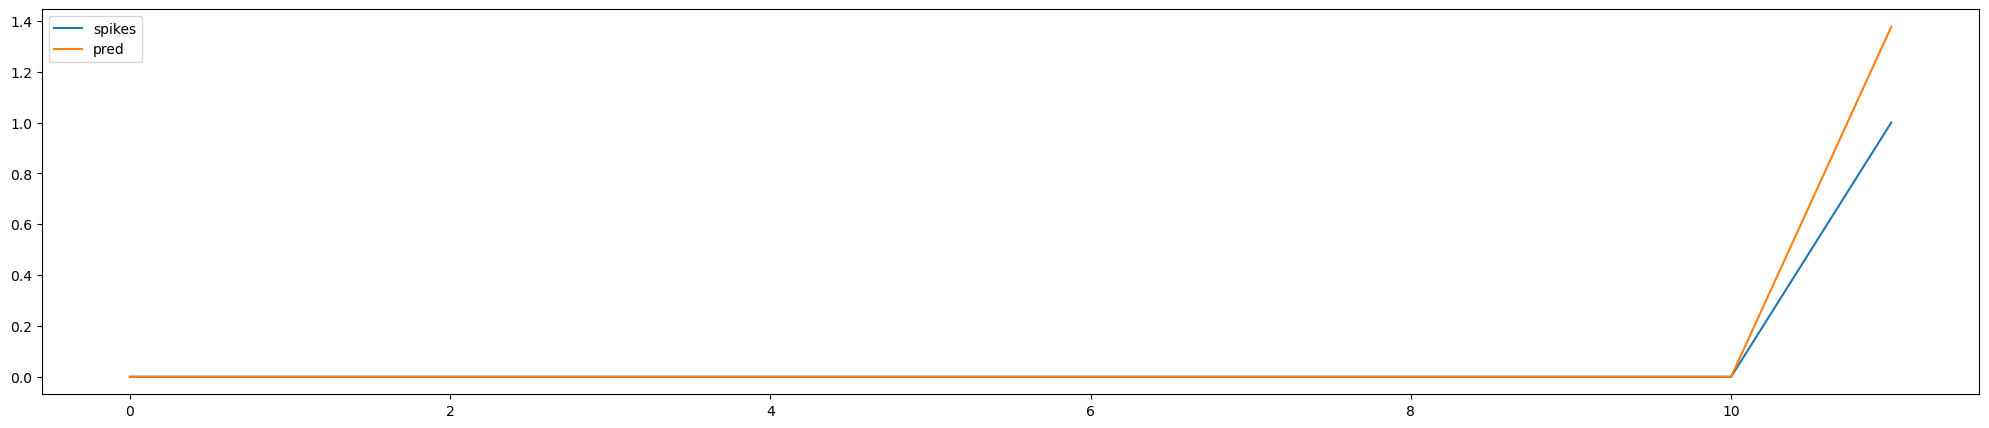

In [28]:
neuron = 716

fig = plt.figure(figsize=(25,5))
plt.plot(robs[:12, neuron]*dfs[:12, neuron], label='spikes')
plt.plot(pred[:12, neuron]*dfs[:12, neuron], label='pred')
plt.legend()
plt.show()

## Load GQMs

In [39]:
all_gqms = np.load('data/2-28_update_all_neuron_GQM_weights_sqrad_0.3_.pkl', allow_pickle=True)
all_gqms.shape

(1491, 60, 60, 11, 3)

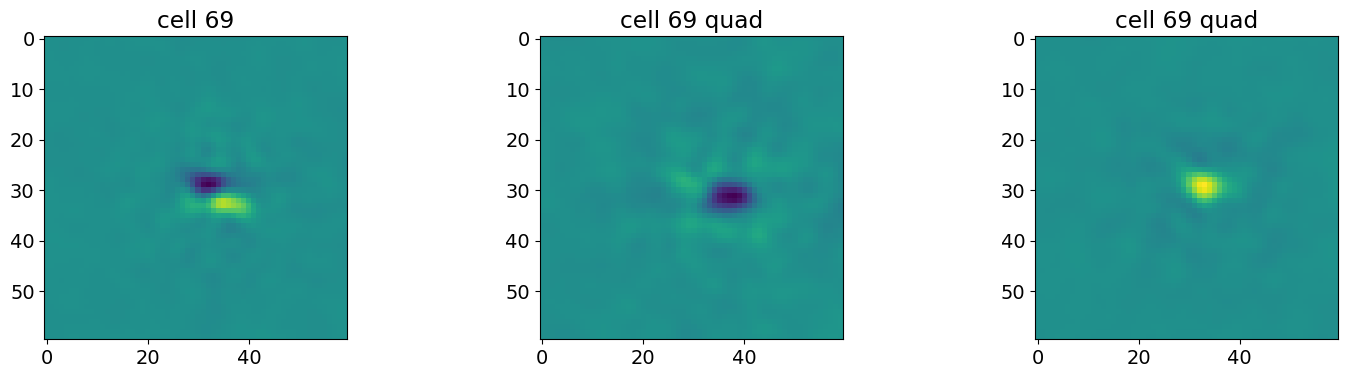

In [40]:
plt.rcParams.update({'font.size': 14})
ss(1,3)
j = 69
plt.subplot(1,3,1)
imagesc(all_gqms[j,:,:,-2,0], balanced=True)
plt.title('cell '+str(j))

plt.subplot(1,3,2)
imagesc(all_gqms[j,:,:,-2,1], balanced=True)
plt.title('cell '+str(j)+' quad')

plt.subplot(1,3,3)
imagesc(all_gqms[j,:,:,-2,2], balanced=True)
plt.title('cell '+str(j)+' quad')

plt.tight_layout()
plt.show()

## Compute DSTRFs for spike times

In [9]:
time_list = np.array([data.train_blks[i] for i in range(0,data.train_blks.shape[0],5)])
time_list.shape

(77,)

In [13]:
spike_pred_times_dict = {cc: [] for cc in cell_list}
for i in range(len(time_list)):
    nt = time_list[i]
    print('### Time', nt)
    pred = cnn_temp(data[nt])
    robs = data[nt]['robs'].detach().cpu().numpy()
    dfs = data[nt]['dfs'].detach().cpu().numpy()
    for j in range(len(cell_list)):
        cc = cell_list[j]
        print('--> Neuron', cc)
        # find times when the neuron spikes and the prediction is above a threshold at the same time
        spike_times = np.where(robs[:,cc]*dfs[:,cc] > 0)[0]
        pred_times = np.where(pred[:,j] > 0.8)[0]
        spike_pred_times = np.intersect1d(spike_times, pred_times) + (block_len*i)
        spike_pred_times_dict[cc].append(spike_pred_times)
        
        print(spike_pred_times)
    print('=======')

for cc in cell_list:
    spike_pred_times_dict[cc] = np.concatenate(spike_pred_times_dict[cc])

### Time 0
--> Neuron 43
[]
--> Neuron 46
[]
--> Neuron 65
[ 42  77  85  95 119 142 173 187 196 205 206 243 256 285 295 296 297 308
 315 316 317 353 388 389 473 518 568 612 616 635 636 675 684 694 699 715
 719 726 727 728 770 787 788 811 842 865 899 942 943 961 973]
--> Neuron 69
[ 39 310 377 441 485 520 723]
--> Neuron 82
[]
--> Neuron 112
[]
--> Neuron 117
[]
--> Neuron 124
[]
--> Neuron 141
[]
--> Neuron 156
[]
--> Neuron 173
[ 25  35  71  78  95  97 118 129 147 159 160 182 186 195 244 266 267 287
 306 314 335 336 369 412 432 434 435 456 457 473 493 502 516 525 526 527
 544 551 563 611 634 635 636 662 673 674 675 682 700 701 799 811 827 828
 830 842 865 895 961 971 972 999]
--> Neuron 177
[]
--> Neuron 208
[]
--> Neuron 212
[ 39 723]
--> Neuron 220
[ 15  39  40  69 189 212 398 429 521 590 773 870]
--> Neuron 221
[]
--> Neuron 241
[296 389 842]
--> Neuron 251
[]
--> Neuron 257
[ 51 118 160 186 243 273 285 286 353 359 389 473 554 621 685 716 727 735
 842 872 873 900]
--> Neuron 263
[3

In [14]:
all_times = np.unique(np.concatenate(list(spike_pred_times_dict.values())))
all_times.shape

(59988,)

In [ ]:
stim = data[0]['stim']
stim.shape

In [ ]:
def core(X):
    with torch.cuda.amp.autocast():
        return cnn_temp.networks[0](X)
def readout(X):
    with torch.cuda.amp.autocast():
        return cnn_temp.networks[1](X)

#dstrf = {cc: [] for cc in cell_list}
for i in range(1):
    tot_start = time()
    #nt = all_times[i]
    X0 = stim[:33,:] #[nt-num_lags+1:nt+1].clone().detach().cpu()
    T = X0.shape[0]
    Y = core(X0).clone().detach().cpu()
    
    start = time()
    jacobian_core = jacfwd(core)(X0)
    end = time()
    print('time', end-start)
    print('core',jacobian_core.shape)
    jacobian_core = jacobian_core.detach().cpu().reshape(((T*jacobian_core.shape[1]),(T*L*L))) #[:,:,0,:]

    start = time()
    jacobian_ro = jacrev(readout)(Y)
    end = time()
    print('time', end-start)
    print('readout',jacobian_ro.shape)
    jacobian_ro = jacobian_ro.detach().cpu().reshape(((T*len(cell_list)),(T*jacobian_ro.shape[3])))

    start = time()
    final_dstrf = jacobian_core.T @ jacobian_ro.squeeze().T
    end = time()
    print('time', end-start)
    
    final_dstrf = final_dstrf.reshape((T,L,L,T,len(cell_list)))
    #for j in range(len(cell_list)):
    #    cc = cell_list[j]
    #    if nt in spike_pred_times_dict[cc]:
    #        print('cell', cc)
    #        dstrf[cc].append(final_dstrf[:,:,:,j].detach().cpu().numpy())
    tot_end = time()
    print('time point', nt, 'complete in', tot_end-tot_start, 'sec')

In [25]:
d2_test1 = dstrf[702][0]
d2_test2 = dstrf[716][0]
d2_test2 = dstrf[782][0]
d2_test1.shape

(40, 40, 11)

In [19]:
d1_test1 = dstrf[702][0]
d1_test2 = dstrf[716][0]
d1_test2 = dstrf[782][0]
d1_test1.shape

(40, 40, 11)

In [26]:
np.sum(d2_test1 != d1_test1)

3928

In [27]:
40*40*11

17600

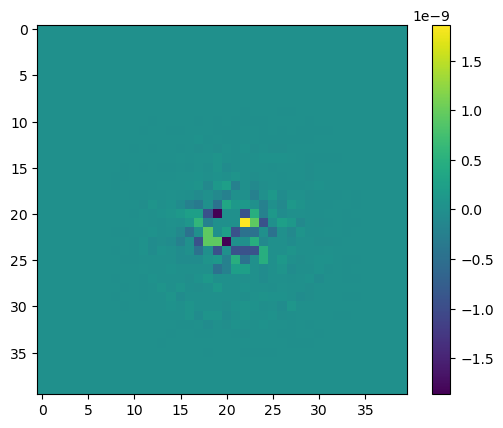

In [39]:
t = 10
imagesc(d2_test1[:,:,5]-d1_test1[:,:,5], balanced=True)
plt.colorbar()

In [40]:
robs = data[time_list]['robs'].detach().cpu().numpy()
dfs = data[time_list]['dfs'].detach().cpu().numpy()
robs.shape

(77000, 1491)

In [45]:
#722, 746, 792
cc = 702
pray = d2_test1
pray.shape

(40, 40, 11)

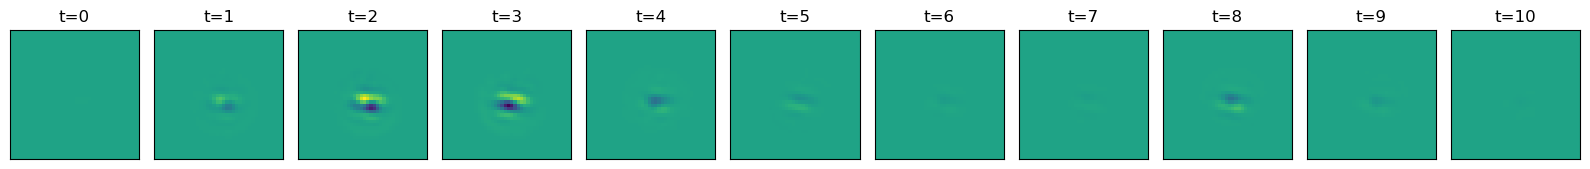

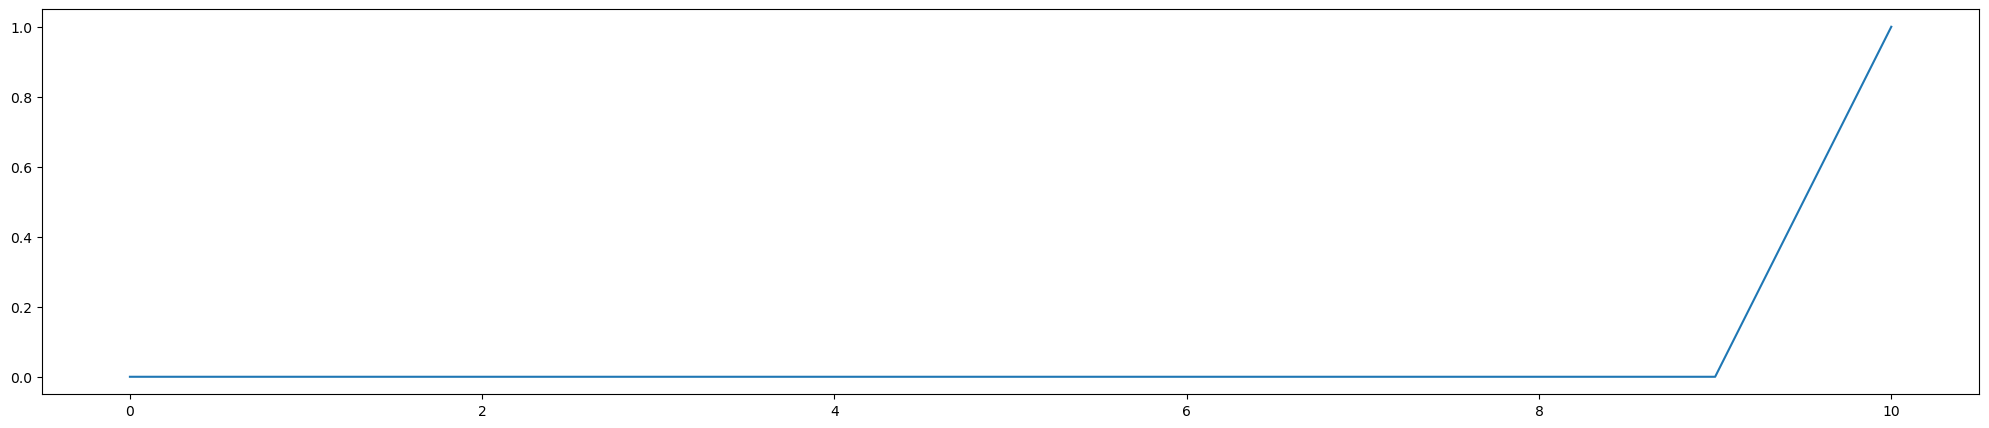

In [46]:
ss(1,11)
cmin = np.min(pray)
cmax = np.max(pray)
for i in range(11):
    plt.subplot(1,11,i+1)
    imagesc(pray[:,:,i], balanced=True)
    plt.title('t='+str(i))
    plt.clim(cmin,cmax)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(25,5))
plt.plot(robs[nt-num_lags+1:nt+1, cc]*dfs[nt-num_lags+1:nt+1, cc])
plt.show()

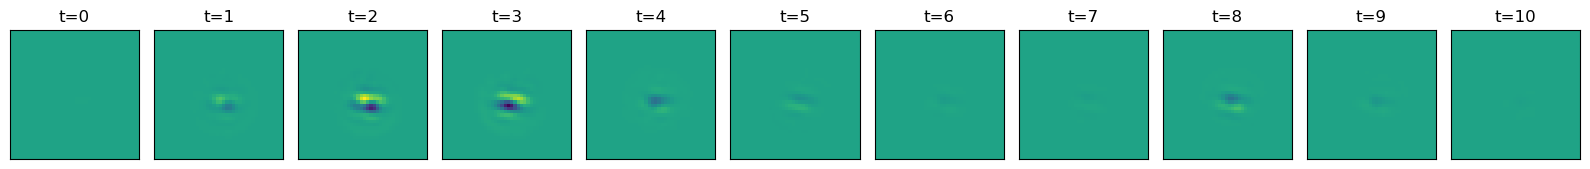

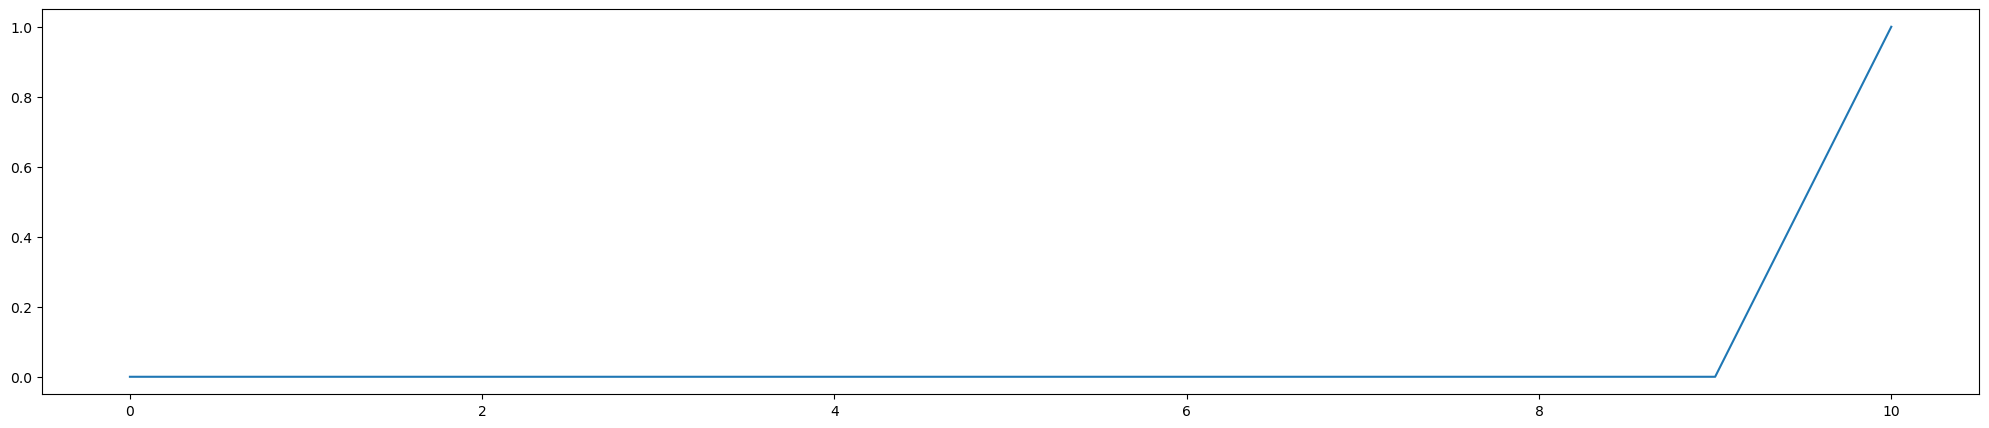

In [44]:
ss(1,11)
cmin = np.min(pray)
cmax = np.max(pray)
for i in range(11):
    plt.subplot(1,11,i+1)
    imagesc(pray[:,:,i], balanced=True)
    plt.title('t='+str(i))
    plt.clim(cmin,cmax)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(25,5))
plt.plot(robs[nt-num_lags+1:nt+1, cc]*dfs[nt-num_lags+1:nt+1, cc])
plt.show()

## Long way (layer by layer)

In [8]:
def func0(X):
    with torch.cuda.amp.autocast():
        return cnn.networks[0].layers[0](X)

In [9]:
X0 = data[0]['stim'][38:40,:].clone().detach()
X0.shape

torch.Size([2, 1600])

In [10]:
Y0 = func0(X0)
Y0.shape

torch.Size([2, 3200])

In [13]:
start = time()
jacobian0 = jacfwd(func0)(X0)
end = time()
print('CPU Time', end-start, 'sec')
jacobian0.shape

CPU Time 0.3164827823638916 sec


torch.Size([2, 3200, 2, 1600])

In [12]:
jacobian0 = jacobian0[:,:,:,:].reshape(((2*L*L),(10*L*L)))
jacobian0.shape

RuntimeError: shape '[3200, 16000]' is invalid for input of size 20480000

In [14]:
def func1(X):
    with torch.cuda.amp.autocast():
        return cnn.networks[0].layers[1](X)

In [15]:
X1 = Y0.clone().detach()
X1.shape

torch.Size([2, 3200])

In [16]:
Y1 = func1(X1)
Y1.shape

torch.Size([2, 38400])

In [17]:
start = time()
jacobian1 = jacfwd(func1)(X1)
end = time()
print('CPU Time', end-start, 'sec')
jacobian1.shape

CPU Time 2.152731418609619 sec


torch.Size([2, 38400, 2, 3200])

In [18]:
def func2(X):
    with torch.cuda.amp.autocast():
        return cnn.networks[0].layers[2](X)

In [19]:
X2 = Y1.clone().detach()
X2.shape

torch.Size([2, 38400])

In [20]:
Y2 = func2(X2)
Y2.shape

torch.Size([2, 38400])

In [21]:
start = time()
jacobian2 = jacfwd(func2)(X2)
end = time()
print('CPU Time', end-start, 'sec')
jacobian2.shape

CPU Time 3.029390573501587 sec


torch.Size([2, 38400, 2, 38400])

In [22]:
def func3(X):
    with torch.cuda.amp.autocast():
        return cnn.networks[0].layers[3](X)

In [23]:
X3 = Y2.clone().detach()
X3.shape

torch.Size([2, 38400])

In [24]:
Y3 = func3(X3)
Y3.shape

torch.Size([2, 19200])

In [25]:
start = time()
jacobian3 = jacrev(func3)(X3)
end = time()
print('CPU Time', end-start, 'sec')
jacobian3.shape

CPU Time 6.359927654266357 sec


torch.Size([2, 19200, 2, 38400])

In [26]:
def func4(X):
    with torch.cuda.amp.autocast():
        return cnn.networks[0].layers[4](X)

In [27]:
X4 = Y3.clone().detach()
X4.shape

torch.Size([2, 19200])

In [28]:
Y4 = func4(X4)
Y4.shape

torch.Size([2, 19200])

In [29]:
start = time()
jacobian4 = jacfwd(func4)(X4)
end = time()
print('CPU Time', end-start, 'sec')
jacobian4.shape

CPU Time 5.0132434368133545 sec


torch.Size([2, 19200, 2, 19200])

In [33]:
dstrf0 = jacobian0.reshape((2*jacobian0.shape[1], 2*jacobian0.shape[3])).squeeze().T 
dstrf1 = dstrf0 @ jacobian1.reshape((2*jacobian1.shape[1], 2*jacobian1.shape[3])).squeeze().T 
dstrf2 = dstrf1 @ jacobian2.reshape((2*jacobian2.shape[1], 2*jacobian2.shape[3])).squeeze().T 
dstrf3 = dstrf2 @ jacobian3.reshape((2*jacobian3.shape[1], 2*jacobian3.shape[3])).squeeze().T 
dstrf4 = dstrf3 @ jacobian4.reshape((2*jacobian4.shape[1], 2*jacobian4.shape[3])).squeeze().T

In [40]:
dstrf1_np = dstrf1.detach().cpu().reshape((2,jacobian0.shape[3],2,jacobian1.shape[1]))
dstrf3_np = dstrf3.detach().cpu().reshape((2,jacobian0.shape[3],2,jacobian3.shape[1]))
dstrf4_np = dstrf4.detach().cpu().reshape((2,jacobian0.shape[3],2,jacobian4.shape[1]))
dstrf1_np.shape, dstrf3_np.shape, dstrf4_np.shape

(torch.Size([2, 1600, 2, 38400]),
 torch.Size([2, 1600, 2, 19200]),
 torch.Size([2, 1600, 2, 19200]))

In [44]:
dstrf_core = torch.cat((dstrf1_np,dstrf3_np,dstrf4_np),axis=3)
dstrf_core.shape

torch.Size([2, 1600, 2, 76800])

In [45]:
def core(X):
    with torch.cuda.amp.autocast():
        return cnn.networks[0](X)

In [46]:
Y_test = core(X0)
Y_test.shape

torch.Size([2, 76800])

In [47]:
def readout(X):
    with torch.cuda.amp.autocast():
        return cnn.networks[1](X)

In [48]:
start = time()
jacobian_ro = jacrev(readout)(Y_test)
end = time()
print('CPU Time', end-start, 'sec')
print(jacobian_ro.shape)

CPU Time 2.646604299545288 sec
torch.Size([2, 1491, 2, 76800])


In [50]:
#jacobian_core2 = jacobian_core[0,:,:,:].reshape((76800,(11*L*L)))
jacobian_core2 = dstrf_core.reshape((2*L*L,2*76800))
jacobian_core2.shape

torch.Size([3200, 153600])

In [51]:
jacobian_ro2 = jacobian_ro[:,:,:,:].reshape((2*1491,2*76800))
jacobian_ro2.shape                                

torch.Size([2982, 153600])

In [52]:
start = time()
final_dstrf = jacobian_core2 @ jacobian_ro2.squeeze().T
end = time()
print('CPU Time', end-start, 'sec')
print(final_dstrf.shape)

CPU Time 1.432645559310913 sec
torch.Size([3200, 2982])


In [53]:
final_dstrf2 = final_dstrf.reshape((2,L,L,2,1491))
final_dstrf2.shape

torch.Size([2, 40, 40, 2, 1491])

In [54]:
pray = final_dstrf2[0,:,:,:,6].detach().cpu().numpy() #.reshape((11,L,L))
pray.shape

(40, 40, 2)

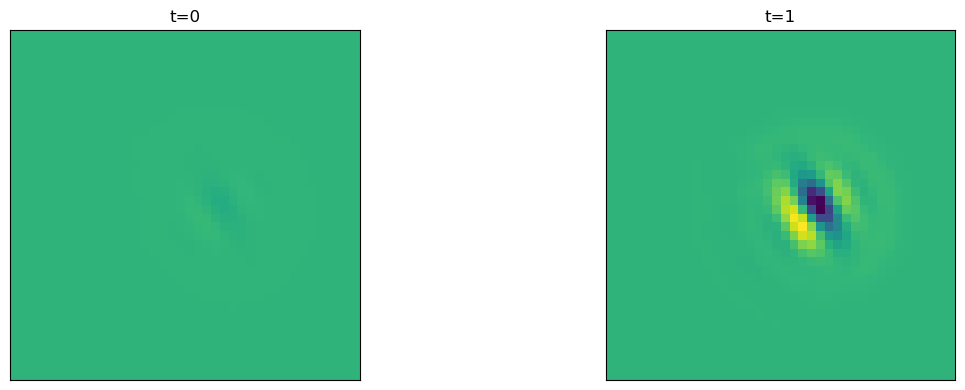

In [56]:
ss(1,2)
cmin = np.min(pray)
cmax = np.max(pray)
for i in range(2):
    plt.subplot(1,2,i+1)
    imagesc(pray[:,:,i], balanced=True)
    plt.title('t='+str(i))
    plt.clim(cmin,cmax)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Test short way
gives almost identical result to long way +/- 1e-11

In [20]:
X0 = data[0]['stim'][35:46,:].clone().detach().cpu()
T = X0.shape[0]
X0.shape, T

(torch.Size([11, 1600]), 11)

In [21]:
def core(X):
    with torch.cuda.amp.autocast():
        return cnn_temp.networks[0](X)

In [22]:
start = time()
jacobian_core = jacfwd(core)(X0)
end = time()
print('CPU Time', end-start, 'sec')
print(jacobian_core.shape)

KeyboardInterrupt: 

In [8]:
def my_torch_function():
    jacobian_core = jacfwd(core)(X0)
    return jacobian_core

peak_mem = memory_usage(
    (my_torch_function, ),
    max_usage=True,
    interval=0.01,   # finer sampling
)

print(f"Peak RAM usage: {peak_mem:.2f} MB")

Peak RAM usage: 263323.51 MB


In [14]:
(peak_mem/1000)*5

1316.6175585937501

In [27]:
Y_test = core(X0)
Y_test.shape

torch.Size([2, 64000])

In [28]:
def readout(X):
    with torch.cuda.amp.autocast():
        return cnn_temp.networks[1](X)

In [29]:
start = time()
jacobian_ro = jacrev(readout)(Y_test)
end = time()
print('CPU Time', end-start, 'sec')
print(jacobian_ro.shape)

CPU Time 0.4028904438018799 sec
torch.Size([2, 1491, 2, 64000])


In [30]:
jacobian_core2 = jacobian_core.reshape(((T*jacobian_core.shape[1]),(T*L*L)))
jacobian_core2.shape

torch.Size([128000, 3200])

In [31]:
jacobian_ro2 = jacobian_ro[:,:,:,:].reshape(((T*NC),(T*jacobian_core.shape[1])))
jacobian_ro2.shape                                

torch.Size([2982, 128000])

In [32]:
start = time()
final_dstrf = jacobian_core2.T @ jacobian_ro2.squeeze().T
end = time()
print('CPU Time', end-start, 'sec')
print(final_dstrf.shape)

CPU Time 1.138962984085083 sec
torch.Size([3200, 2982])


In [33]:
final_dstrf2 = final_dstrf.reshape((T,L,L,T,NC))
final_dstrf2.shape

torch.Size([2, 40, 40, 2, 1491])

In [34]:
pray2 = final_dstrf2[0,:,:,:,69].detach().cpu().numpy() #.reshape((11,L,L))
pray2.shape

(40, 40, 2)

In [23]:
pray = final_dstrf2[0,:,:,:,69].detach().cpu().numpy() #.reshape((11,L,L))
pray.shape

(40, 40, 2)

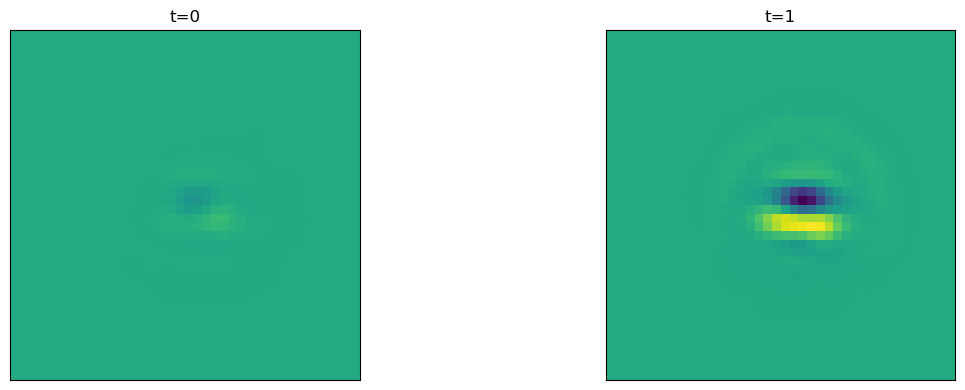

In [35]:
ss(1,2)
cmin = np.min(pray2)
cmax = np.max(pray2)
for i in range(2):
    plt.subplot(1,2,i+1)
    imagesc(pray2[:,:,i], balanced=True)
    plt.title('t='+str(i))
    plt.clim(cmin,cmax)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

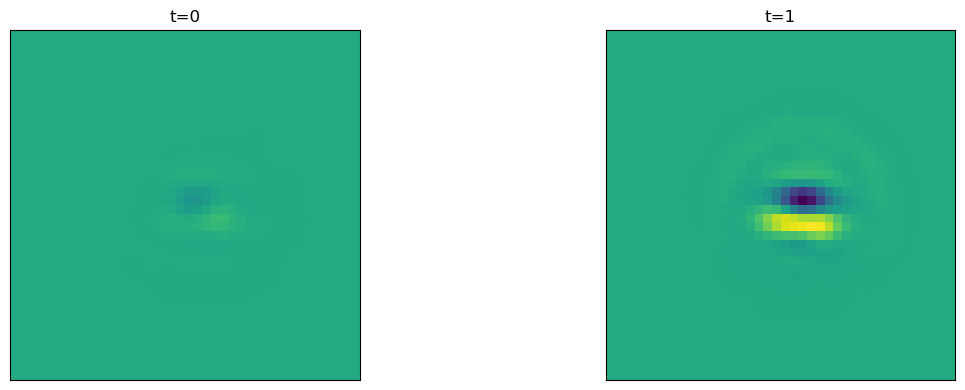

In [24]:
ss(1,2)
cmin = np.min(pray)
cmax = np.max(pray)
for i in range(2):
    plt.subplot(1,2,i+1)
    imagesc(pray[:,:,i], balanced=True)
    plt.title('t='+str(i))
    plt.clim(cmin,cmax)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

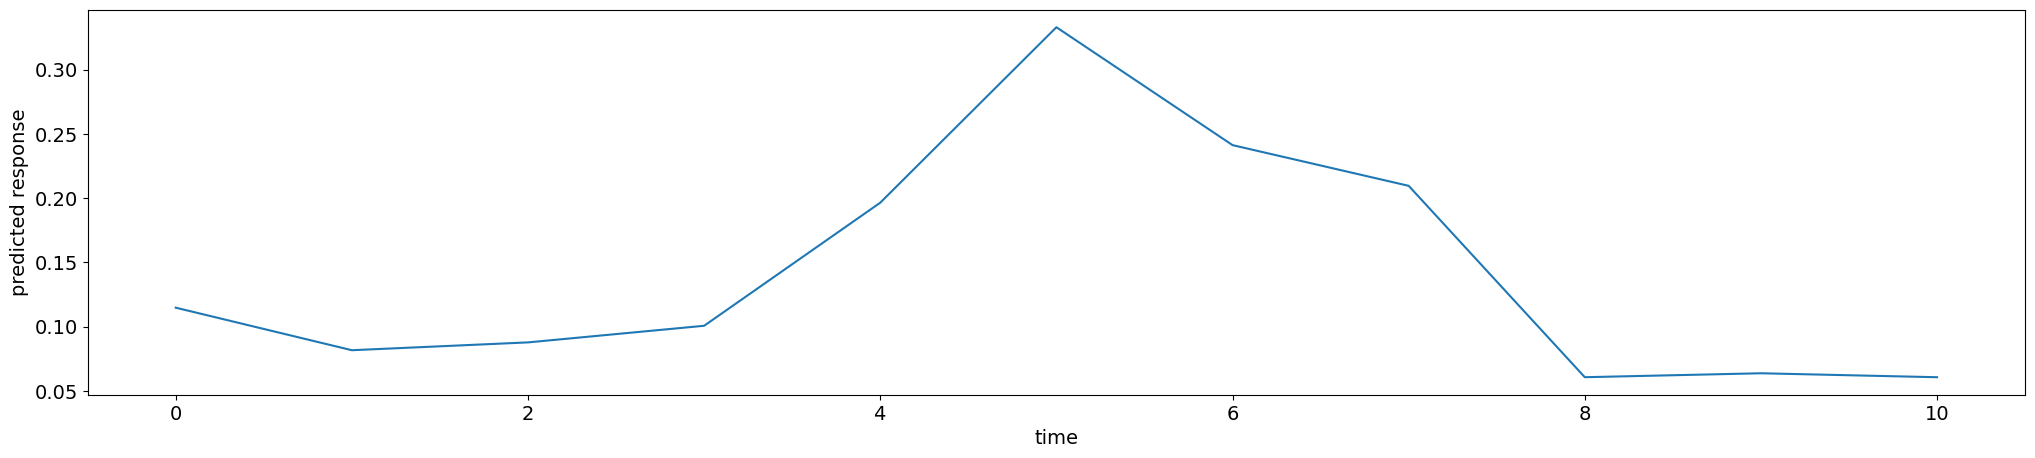

In [22]:
neuron = 6
start = 35
end = 46

fig = plt.figure(figsize=(25,5))
plt.plot(pred[start:end, neuron]*dfs[start:end, neuron])
plt.xlabel('time')
plt.ylabel('predicted response')
plt.show()

In [36]:
np.sum(pray2[:,:,0] != pray[:,:,0])

0

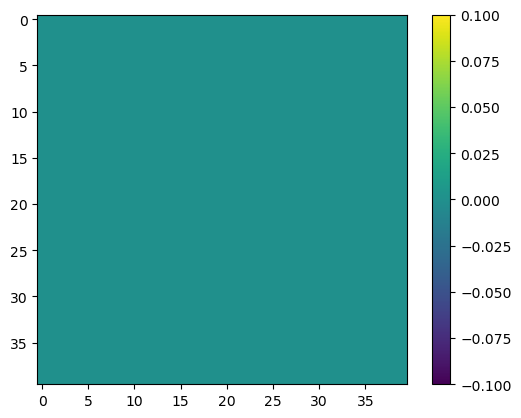

In [37]:
imagesc(pray2[:,:,0]-pray[:,:,0], balanced=True)
plt.colorbar()

## Even easier way (Does not work!)

In [23]:
X0 = data[0]['stim'][35:46,:].clone().detach()
X0.shape

torch.Size([11, 1600])

In [24]:
def func(X):
    with torch.cuda.amp.autocast():
        out1 = cnn.networks[0](X)
        out2 = cnn.networks[1](out1)
        return out2

In [25]:
jacobian = jacrev(func)(X0)
jacobian.shape

torch.Size([11, 1491, 11, 1600])

In [26]:
final_dstrf3 = jacobian.detach().cpu().numpy().reshape((11,L,L,11,1491))
final_dstrf3.shape

(11, 40, 40, 11, 1491)

In [36]:
pray2 = final_dstrf3[0,:,:,:,6]
pray2.shape

(40, 40, 11)

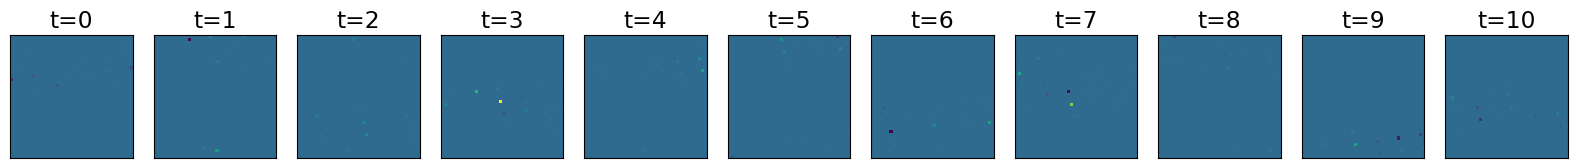

In [37]:
ss(1,11)
cmin = np.min(pray2)
cmax = np.max(pray2)
for i in range(11):
    plt.subplot(1,11,i+1)
    imagesc(pray2[:,:,i], balanced=True)
    plt.title('t='+str(i))
    plt.clim(cmin,cmax)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()

## Old stuff

In [6]:
robs = data[:]['robs'].detach().cpu().numpy()
dfs = data[:]['dfs'].detach().cpu().numpy()
robs.shape, dfs.shape

((480000, 1491), (480000, 1491))

In [6]:
gdata = GenericDataset( {'stim': data[:]['stim'], 
                        'robs': data[:]['robs'], 
                        'dfs':data[:]['dfs']}, device=device0)

In [11]:
neurons = [0] #, 656, 1025, 1312]

spike_pred_times_neurons = {neuron: [] for neuron in neurons}
for nt in range(2):
    print('### Time', nt)
    results_3iter = predict.predict(cnn, dataset=data[nt], calc_jacobian=False, verbose=False)
    robs = data[nt]['robs'].detach().cpu().numpy()
    dfs = data[nt]['dfs'].detach().cpu().numpy()
    for neuron in neurons:
        print('--> Neuron', neuron)
        # find times when the neuron spikes and the prediction is above a threshold at the same time
        spike_times = np.where(robs[:,neuron]*dfs[:,neuron] > 0)[0]
        pred_times = np.where(results_3iter.pred[:,neuron] > 0.8)[0]
        spike_pred_times = np.intersect1d(spike_times, pred_times) + (block_len*nt)
        spike_pred_times_neurons[neuron].append(spike_pred_times)
        
        print(spike_pred_times)
    print('=======')

for neuron in neurons:
    spike_pred_times_neurons[neuron] = np.concatenate(spike_pred_times_neurons[neuron])

### Time 0
--> Neuron 0
[ 15  16  17  39 122 164 184 213 231 232 252 292 300 318 342 363 386 441
 522 712 723 724 757 789 802 803 953]
### Time 1
--> Neuron 0
[1014 1026 1053 1054 1108 1143 1193 1194 1208 1264 1265 1285 1293 1331
 1347 1349 1382 1384 1392 1420 1506 1523 1535 1579 1611 1612 1674 1795
 1902 1903 1923 1998]


In [12]:
pred_cell0 = cnn(gdata[spike_pred_times_neurons[neuron]])
pred_cell0.shape

torch.Size([59, 1491])

In [13]:
robs = data[:2]['robs'].detach().cpu().numpy()
dfs = data[:2]['dfs'].detach().cpu().numpy()

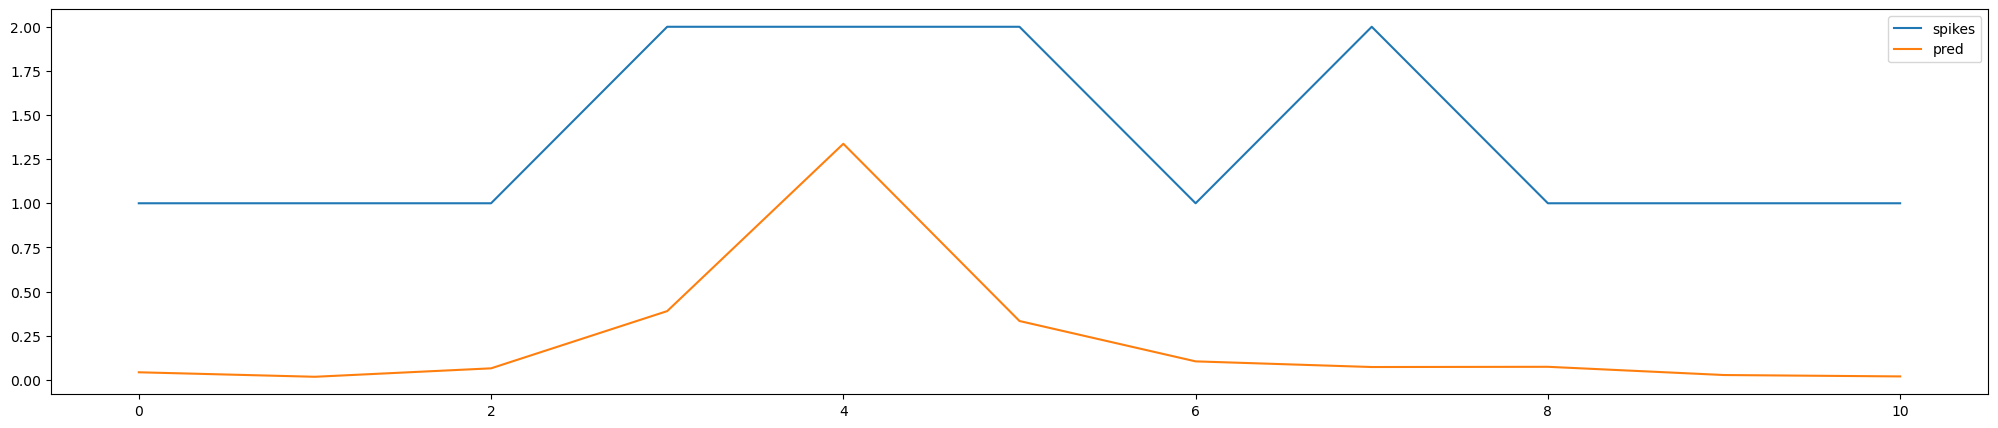

In [14]:
neuron = 0
start = 8
end = 19

fig = plt.figure(figsize=(25,5))
plt.plot(robs[spike_pred_times_neurons[neuron][start:end], neuron]*dfs[spike_pred_times_neurons[neuron][start:end], neuron], label='spikes')
plt.plot(pred_cell0[start:end, neuron].detach().numpy(), label='pred')
plt.legend()
plt.show()

In [15]:
def func(X):
    return cnn.networks[0].layers[0](X)

In [19]:
cnn.networks[0].layers[0].input_dims

[1, 40, 40, 1]

In [16]:
X = gdata[spike_pred_times_neurons[neuron][start:end]]['stim']
X.shape

torch.Size([11, 1600])

In [17]:
Y = func(X)
Y.shape

torch.Size([11, 3200])

In [18]:
jacobian = jacrev(func)(X)
jacobian.shape

torch.Size([11, 3200, 11, 1600])

In [15]:
layer_jacobians = []
for i in range(5):
    jacobian = jacrev(func)(X[i,:])
    layer_jacobians.append(jacobian)

In [17]:
layer_jacobians[0].shape

torch.Size([1, 3200, 1600])

In [18]:
stacked_jacobians = torch.vstack(layer_jacobians)
stacked_jacobians.shape

torch.Size([5, 3200, 1600])

In [21]:
stacked_jacobians.reshape(stacked_jacobians.shape[0], cnn.networks[0].layers[0].num_filters, data.stim_dims[1], cnn.networks[0].layers[0].num_lags, -1).shape

torch.Size([5, 2, 40, 10, 6400])

In [14]:
cnn.networks[0].layers[0].num_filters, cnn.networks[0].layers[0].num_lags, 

(2, 10)

In [ ]:
X = gdata[spike_pred_times_neurons[neuron][start:end]]['stim']
prev_out = []
jacobian_list = []
# core jacobian
for ll in range(4):
    def func(X):
        return cnn.networks[0].layers[ll](X)
    layer_jacobians = []
    for i in range(end-start):
        if ll == 0:
            jacobian = jacrev(func)(X[i,:])
        else:
            jacobian = jacrev(func)(prev_out[ll-1][i,:])
        layer_jacobians.append(jacobian)
    stacked_jacobians = torch.vstack(layer_jacobians)
    jacobian_list.append(stacked_jacobians)
    print('layer',ll,'jacobian computed')

    if ll == 0:
        prev_out.append(func(X))
    else:
        prev_out.append(func(prev_out[ll-1]))
    print(prev_out[ll].shape)

layer 0 jacobian computed
torch.Size([11, 3200])


In [ ]:
results_cell0 = predict.predict(cnn, dataset=gdata[spike_pred_times_neurons[neuron][start:end]], calc_jacobian=True, verbose=True)

num_inps 5
prev_output shape torch.Size([5, 1600]) ni 0 scaffold3d li 0


 20%|█████████                                    | 1/5 [00:01<00:06,  1.62s/it]

Jacobian shape: torch.Size([1, 3200, 1600])


 40%|██████████████████                           | 2/5 [00:02<00:04,  1.36s/it]

Jacobian shape: torch.Size([1, 3200, 1600])


 60%|███████████████████████████                  | 3/5 [00:04<00:02,  1.31s/it]

Jacobian shape: torch.Size([1, 3200, 1600])


 80%|████████████████████████████████████         | 4/5 [00:05<00:01,  1.28s/it]

Jacobian shape: torch.Size([1, 3200, 1600])


100%|█████████████████████████████████████████████| 5/5 [00:06<00:00,  1.30s/it]


Jacobian shape: torch.Size([1, 3200, 1600])
torch.Size([5, 1600]) --> torch.Size([5, 3200])
prev_output shape torch.Size([5, 3200]) ni 0 scaffold3d li 1


  0%|                                                     | 0/5 [00:00<?, ?it/s]

In [8]:
results_cell0 = predict.predict(cnn, dataset=gdata[:2], calc_jacobian=True, verbose=True)

num_inps 2
prev_output shape torch.Size([2, 1600]) ni 0 scaffold3d li 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:03<00:00,  1.86s/it]


torch.Size([2, 1600]) --> torch.Size([2, 3200])
prev_output shape torch.Size([2, 3200]) ni 0 scaffold3d li 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [07:44<00:00, 232.41s/it]


torch.Size([2, 3200]) --> torch.Size([2, 153600])
prev_output shape torch.Size([2, 153600]) ni 0 scaffold3d li 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [08:22<00:00, 251.23s/it]


torch.Size([2, 153600]) --> torch.Size([2, 153600])
prev_output shape torch.Size([2, 153600]) ni 0 scaffold3d li 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [07:53<00:00, 236.82s/it]


torch.Size([2, 153600]) --> torch.Size([2, 115200])
prev_output shape torch.Size([2, 115200]) ni 0 scaffold3d li 4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [08:53<00:00, 266.60s/it]


torch.Size([2, 115200]) --> torch.Size([2, 115200])
prev_output shape torch.Size([2, 115200]) ni 1 readout li 0


  0%|                                                                                                                   | 0/2 [00:00<?, ?it/s]


RuntimeError: shape '[-1, 40, 40, 40, 6]' is invalid for input of size 115200

In [36]:
cnn.networks[1].network_type

'readout'

In [ ]:
results_cell0.jacobian.shape

In [ ]:
plot.imagesc(results_cell0.jacobian[0,0,neuron,:].reshape(36,14), cmap='gray_r', origin='lower')
plt.title('DSTRF', fontsize=16)

In [14]:
results.jacobian

[]

In [9]:
imagesc(results_.jacobian[timepoint,0,neuron,:].reshape(36,14), cmap='gray_r', origin='lower')

[1, 40, 40, 1]